In [2]:
#设置成嵌入显示
%matplotlib inline 

import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

In [3]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs,
                       dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b

#设置噪声，即数据集中无意义的干扰，噪声服从正态分布
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

In [4]:
print(features)
print(labels.size())

tensor([[ 0.1226,  0.6902],
        [ 0.7708,  0.1600],
        [-0.4676, -0.4634],
        ...,
        [-1.6041,  2.1126],
        [-0.0305,  0.9397],
        [-0.4182, -1.7750]])
torch.Size([1000])


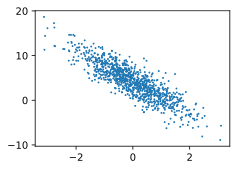

In [5]:
#生成第二个特征和标签的散点图

def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')
    
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    #设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize
    
set_figsize()
plt.scatter(features[:,1].numpy(), labels.numpy(), 1)
plt.show()

In [6]:
#遍历数据集并且不断读取小批量数据样本
#函数每次返回batch_size（批量大小）个随机样本的特征和标签

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 样本的读取顺序是随机的
    random.shuffle(indices)  
    for i in range(0, num_examples, batch_size):
        # 最后一次可能不足一个batch
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) 
        yield  features.index_select(0, j), labels.index_select(0, j)

In [7]:
batch_size = 10

for X,y in data_iter(batch_size, features, labels):
    print(X)
    print(y)
    break

tensor([[ 2.2875,  0.4073],
        [-0.1460, -3.0901],
        [ 0.4825, -2.2819],
        [ 0.3774, -0.2208],
        [ 0.9343,  1.3046],
        [ 0.6770,  0.0162],
        [ 1.3753,  0.4972],
        [-0.4458, -1.9168],
        [ 1.0428, -0.0635],
        [-1.6991, -1.5857]])
tensor([ 7.3759, 14.4223, 12.9284,  5.6921,  1.6442,  5.5139,  5.2542,  9.8460,
         6.4984,  6.1790])


In [8]:
#初始化模型参数
#将权重初始化为均值为0，标准差为0.01的正态随机数，偏差初始化为0

w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

print(w, b)

#让参数能够求梯度并迭代
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([[0.0175],
        [0.0005]]) tensor([0.])


tensor([0.], requires_grad=True)

In [9]:
#定义线性回归模型
#使用mm函数做矩阵乘法
def linreg(X, w, b):
    return torch.mm(X, w) + b

#定义损失函数
def squared_loss(y_hat, y):
    #这里返回的是向量
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

#定义优化算法
#这里自动求梯度得到的是批量样本的梯度和，需要将其除以批量大小得到平均值
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

In [10]:
lr = 0.03   #学习率
num_epochs = 3    #迭代周期个数
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  
    #训练模型一共需要num_epochs个迭代周期
    #在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）
    #X和y分别是小批量样本的特征和标签
    
    for X, y in data_iter(batch_size, features, labels):
        # l是有关小批量X和y的损失，调用sum()变为标量方可求梯度
        l = loss(net(X, w, b), y).sum()  
        # 小批量的损失对模型参数求梯度
        l.backward()  
        #使用小批量随机梯度下降迭代模型参数
        sgd([w, b], lr, batch_size)  

        #梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
        
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.035479
epoch 2, loss 0.000122
epoch 3, loss 0.000050


In [11]:
#比较学到的参数和用来生成训练集的真实参数

print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0000],
        [-3.3997]], requires_grad=True)
4.2 
 tensor([4.1999], requires_grad=True)


In [12]:
# 线性规划的简洁实现

In [13]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3, 4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [14]:
import torch.utils.data as Data
# 读取数据

batch_size = 10
#将训练数据的标签和特征组合
dataset = Data.TensorDataset(features, labels)
#随机读取小批量
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

for X,y in data_iter:
    print(X, y)
    break

tensor([[ 1.3781,  1.0497],
        [ 0.7429, -1.2312],
        [ 0.1446, -0.0313],
        [ 0.0406,  1.0496],
        [ 0.2178,  1.1486],
        [-0.4739,  0.7034],
        [ 0.2837,  0.0923],
        [-1.3437, -1.1731],
        [-0.2003,  1.1843],
        [-0.9444, -0.6468]]) tensor([3.7997, 9.3728, 4.5960, 1.1289, 1.1961, 1.1420, 4.4774, 5.0429, 0.2461,
        4.2677])


In [17]:
import torch.nn as nn
# 定义模型

class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
        
    # forward定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(num_inputs)
print(net)   # 打印出网络的结构

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [18]:
# 写法一
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # 此处还可以传入其他层
    )

# 写法二
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

# 写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [19]:
from torch.nn import init
# 初始化模型参数

#将每个元素初始化为随机采样于均值为0，标准差为0.01的正态分布
init.normal_(net[0].weight, mean=0, std=0.01)
init.constant_(net[0].bias, val=0)

Parameter containing:
tensor([0.], requires_grad=True)

In [20]:
# 定义损失函数
loss = nn.MSELoss()

In [21]:
import torch.optim as optim
# 定义优化算法

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [23]:
# 训练模型

num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000130
epoch 2, loss: 0.000068
epoch 3, loss: 0.000078


In [24]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3, 4] Parameter containing:
tensor([[ 2.0012, -3.0005]], requires_grad=True)
4.2 Parameter containing:
tensor([4.2003], requires_grad=True)
